In [46]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [48]:
# Load the prepared data
X = np.load('../data/X_12hr_noC.npy')
y = np.load('../data/y_12hr_noC.npy')


In [50]:
X.shape

(18684, 48, 51)

In [52]:
y.shape

(18684,)

In [54]:
count_ones = np.sum(y == 1)

count_zeros = np.sum(y == 0)

print(f"Number of 1s: {count_ones}")
print(f"Number of 0s: {count_zeros}")

Number of 1s: 7146
Number of 0s: 11538


In [56]:
X[0].shape

(48, 51)

In [64]:
X[0]

array([[-0.5838156 , -0.83226839, -0.87021806, ..., -0.81995338,
        -0.83657196, -0.63227399],
       [-0.5838156 , -0.83226839, -0.87021806, ..., -0.81995338,
        -0.83657196, -0.63227399],
       [-0.5838156 , -0.83226839, -0.87021806, ..., -0.81995338,
        -0.83657196, -0.63227399],
       ...,
       [ 1.71286961,  1.30046224,  1.11951536, ...,  1.00426795,
         1.07260733,  0.99941018],
       [ 1.71286961,  1.30046224,  1.11951536, ...,  1.00426795,
         1.07260733,  1.27189965],
       [ 1.71286961,  1.30046224,  1.11951536, ...,  1.86688424,
         1.07260733,  1.96907993]])

In [66]:
X[0][15]

array([-0.5838156 , -0.83226839, -0.87021806, -0.81668228, -0.00671511,
       -0.0081038 , -0.00252973, -0.04257916, -0.1777405 , -0.13991717,
       -0.8776438 , -0.87077997, -0.76882845, -0.86632688, -0.87705029,
       -0.78077231, -0.8656789 , -0.87771351, -0.8778228 , -0.8636756 ,
       -0.84660642, -0.85720765, -0.4283515 , -0.87646156, -0.87746466,
       -0.87726894, -0.87752724, -0.87748472, -0.5384339 , -0.86857284,
       -0.85125914, -0.8731804 , -0.87755315, -0.87748446, -0.74504112,
       -0.87549827, -0.87337109, -0.87656595, -0.87599855, -0.87264028,
       -0.48631989, -0.83061955, -0.87703159, -0.02619847, -0.01884388,
       -0.87687715, -0.83650512, -0.87406153, -0.81995338, -0.83657196,
       -0.63227399])

In [68]:
unique_values, counts = np.unique(y, return_counts=True)

# Print the results
for value, count in zip(unique_values, counts):
    print(f'Value {value} occurs {count} times')

Value 0 occurs 11538 times
Value 1 occurs 7146 times


In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [72]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, LSTM, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

# Define Transformer Encoder Layer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.3):
    # Multi-Head Self-Attention
    attention = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    attention = Dropout(dropout)(attention)
    attention = Add()([attention, inputs])  # Residual connection
    attention = LayerNormalization(epsilon=1e-6)(attention)  # Layer normalization

    # Feed-forward network
    ff = Dense(ff_dim, activation='relu')(attention)
    ff = Dropout(dropout)(ff)
    ff = Dense(inputs.shape[-1])(ff)  # Project back to original input shape
    ff = Add()([ff, attention])  # Residual connection
    ff = LayerNormalization(epsilon=1e-6)(ff)  # Layer normalization
    return ff

# Input layer for feature data (shape: 48 time steps, 51 features)
inputs = Input(shape=(48, 51))

# Transformer encoder layers for feature data
x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.3)
x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.3)

# LSTM layers to capture sequential dependencies
x = LSTM(64, activation='relu', return_sequences=True)(x)
x = LSTM(32, activation='relu')(x)

# Fully connected layer
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)

# Output layer for binary classification
outputs = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 48, 51)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_4        │ (None, 48, 51)            │          53,043 │ input_layer_2[0][0],       │
│ (MultiHeadAttention)          │                           │                 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_15 (Dropout)          │ (None, 48, 51)            │               0 │ multi_head_attention_4[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_8 (Add)                   │ (None, 48, 51)            │               0 │ dropout_15[0][0],          │
│                               │                           │                 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_8         │ (None, 48, 51)            │             102 │ add_8[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_12 (Dense)              │ (None, 48, 128)           │           6,656 │ layer_normalization_8[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_16 (Dropout)          │ (None, 48, 128)           │               0 │ dense_12[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_13 (Dense)              │ (None, 48, 51)            │           6,579 │ dropout_16[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_9 (Add)                   │ (None, 48, 51)            │               0 │ dense_13[0][0],            │
│                               │                           │                 │ layer_normalization_8[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_9         │ (None, 48, 51)            │             102 │ add_9[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_5        │ (None, 48, 51)            │          53,043 │ layer_normalization_9[0][… │
│ (MultiHeadAttention)          │                           │                 │ layer_normalization_9[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_18 (Dropout)          │ (None, 48, 51)            │               0 │ multi_head_attention_5[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_10 (Add)                  │ (None, 48, 51)            │               0 │ dropout_18[0][0],          │
│                               │                           │                 │ layer_normalization_9[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_10        │ (None, 48, 51)            │             10

 Total params: 176,165 (688.14 KB)

 Trainable params: 176,165 (688.14 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:

# from tensorflow.keras.callbacks import EarlyStopping
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



# # Train the model with Early Stopping
# history = model.fit(X_train, 
#                     y_train, 
#                     epochs=30, 
#                     batch_size=64, 
#                     validation_split=0.2)

# # Save the model
# # model.save('lstm_model_advanced.h5')

# # Save the model
# # model.save('lstm_model_advanced.h5')




history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2)



Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.6649 - loss: 0.6173 - val_accuracy: 0.7485 - val_loss: 0.5328
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.7411 - loss: 0.5426 - val_accuracy: 0.7585 - val_loss: 0.5099
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.7597 - loss: 0.5153 - val_accuracy: 0.7689 - val_loss: 0.4980
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.7715 - loss: 0.5033 - val_accuracy: 0.7783 - val_loss: 0.4898
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.7764 - loss: 0.4896 - val_accuracy: 0.7796 - val_loss: 0.4833
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.7782 - loss: 0.4880 - val_accuracy: 0.7766 - val_loss: 0.5000
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.7875 - loss: 0.4822 - val_accuracy: 0.7853 - val_loss: 0.4763
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.7779 - loss: 0.4793 - val_acc

In [76]:
# model.save('lstm_transformer_model_50epoch.h5')

In [78]:
# Step 3: Evaluate the model
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score

y_pred = (model.predict(X_test) > 0.5).astype(int)

# Calculate precision, recall, F1 score, and accuracy
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Print results
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Accuracy: {accuracy:.2f}')


117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Precision: 0.73
Recall: 0.69
F1 Score: 0.71
Accuracy: 0.78


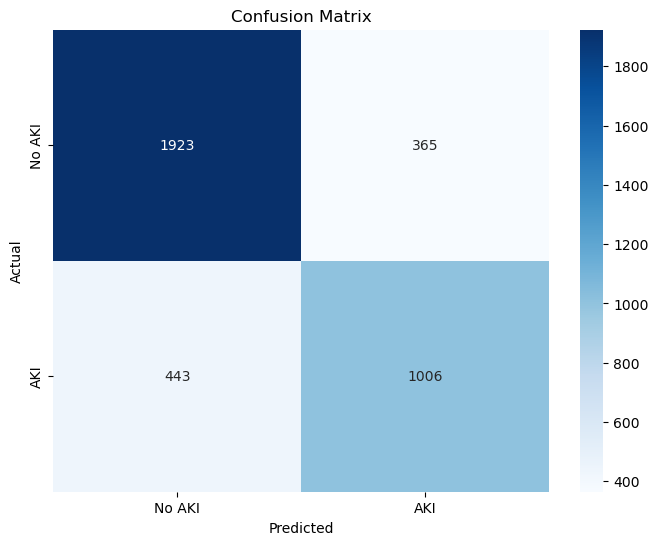

In [80]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No AKI', 'AKI'], yticklabels=['No AKI', 'AKI'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

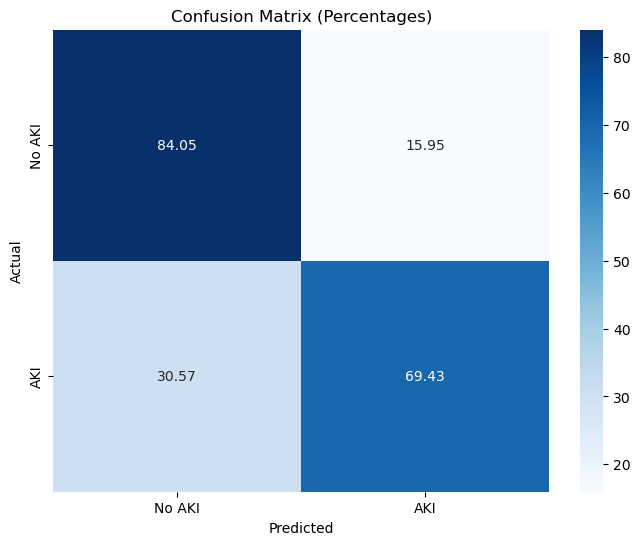

In [82]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Convert to percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot Confusion Matrix as percentages
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', xticklabels=['No AKI', 'AKI'], yticklabels=['No AKI', 'AKI'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Percentages)')
plt.show()

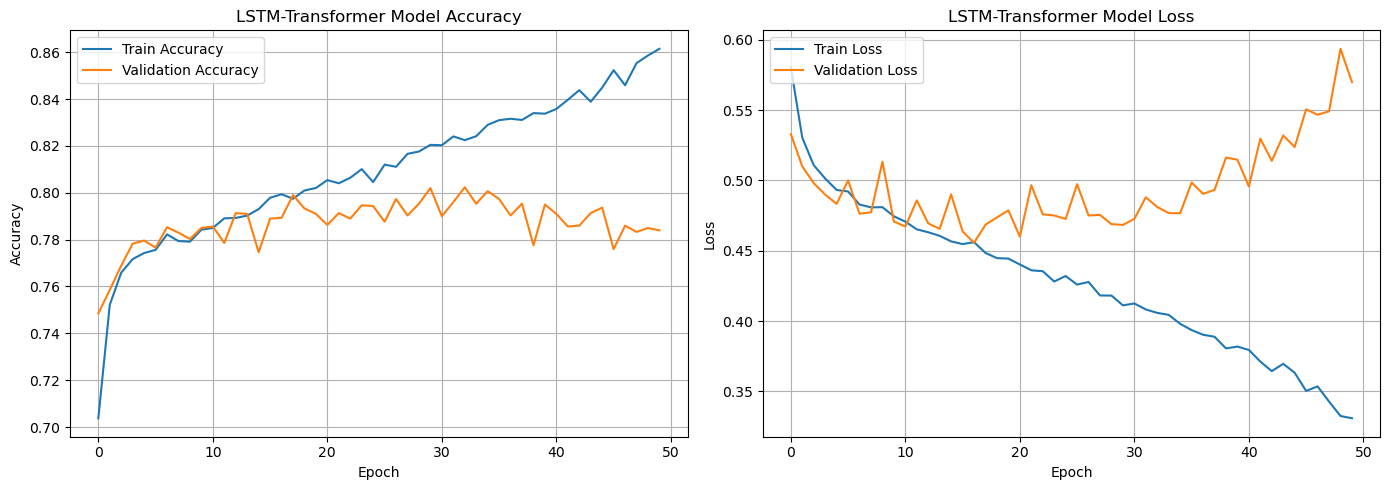

In [84]:
import matplotlib.pyplot as plt


# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM-Transformer Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM-Transformer Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()


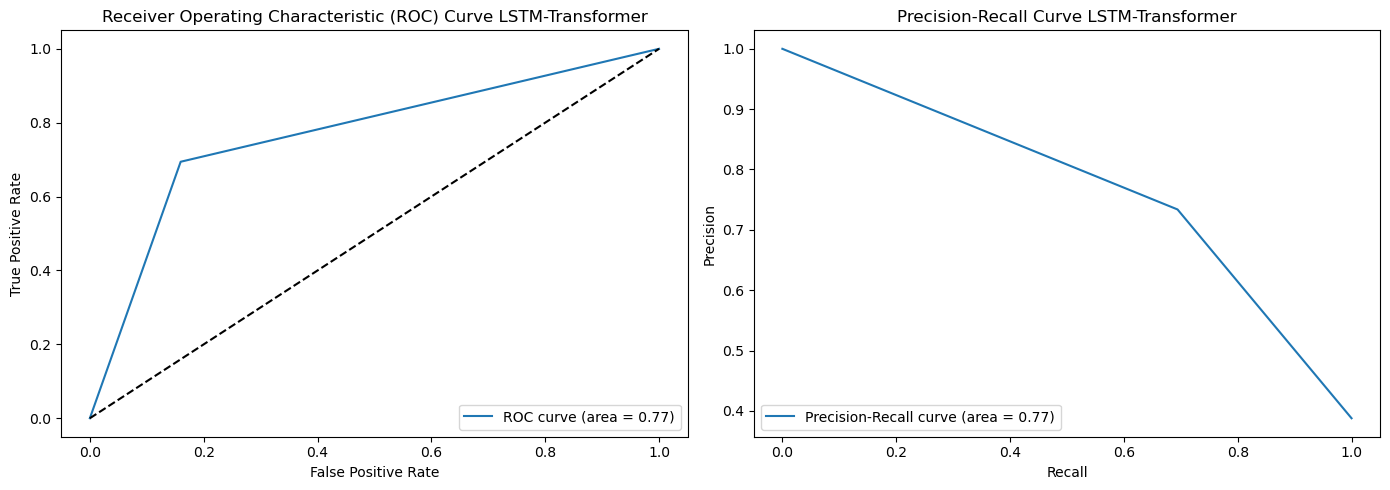

In [87]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

# Assuming y_true are the true labels and y_scores are the predicted probabilities

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred)

# Calculate Precision-Recall curve and AUPRC
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
auprc = auc(recall, precision)

# Plot ROC curve
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auroc)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Receiver Operating Characteristic (ROC) Curve LSTM-Transformer')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Plot Precision-Recall curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label='Precision-Recall curve (area = %0.2f)' % auprc)
plt.title('Precision-Recall Curve LSTM-Transformer')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()